# Kaggle's Heart Disease Classification
- https://www.kaggle.com/competitions/heart-disease-uci/overview
 
 
#### 1. Problem Definition
- Given clinical parameters about a patient, can we predict whether or not they have heart disease?


#### 2. Data 
- Original data is from the Cleveland data and from UCI Machine Learning Repository 
    - https://archive.ics.uci.edu/ml/datasets/heart+disease

- Downloaded in CSV format from Kaggle
https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
    - includes data dictionary


#### 4. Features - Data Dictionary

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
  - 0: Typical angina: chest pain related decrease blood supply to the heart
  - 1: Atypical angina: chest pain not related to heart
  - 2: Non-anginal pain: typically esophageal spasms (non heart related)
  - 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
 - serum = LDL + HDL + .2 * triglycerides
 - above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
'>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    0: Nothing to note
    1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    - 0: Upsloping: better heart rate with excercise (uncommon)
    - 1: Flatsloping: minimal change (typical healthy heart)
    - 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    - colored vessel means the doctor can see the blood passing through
    - the more blood movement the better (no clots)
13. thal - thalium stress result
    - 1,3: normal
    - 6: fixed defect: used to be defect but ok now
    - 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

### Import Tools

In [74]:
import catboost as cb
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve


### Import data

In [73]:
heart_disease = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/heart-disease.csv")

# Exploratory data analysis
- What kinds of data do we have? 
- Is there missing data?
- What are the outliers?

### View data types

In [3]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Check for null values

In [4]:
heart_disease.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### View Labels distribution

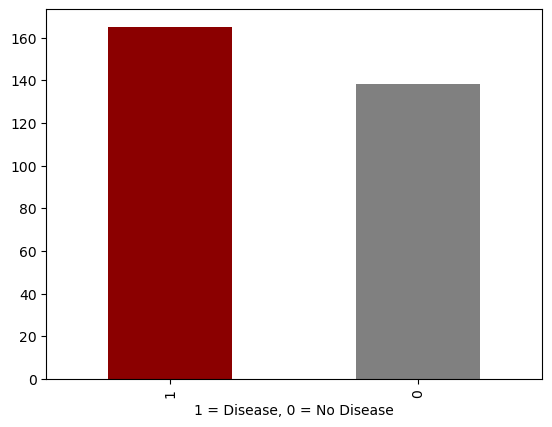

In [99]:
heart_disease["target"].value_counts().plot(kind="bar",
                                           color = ('darkred','grey'),
                                           xlabel = "1 = Disease, 0 = No Disease");



### Observations: 
- Data types are numerical with no null values
- Target classes are relatively balanced

## Finding patterns within columns 

### Sex to Target comparison

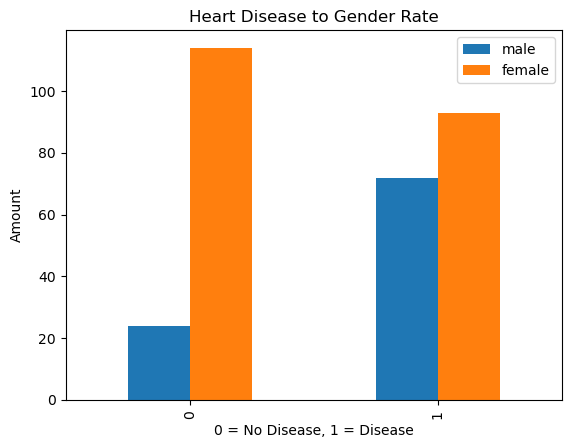

In [76]:
pd.crosstab(heart_disease.target, heart_disease.sex).plot.bar(
title = "Heart Disease to Gender Rate",
xlabel = "0 = No Disease, 1 = Disease",
ylabel = "Amount",
);
plt.legend(("male", "female"));

### Observations:
- Dataset includes a 47% female to male ratio
- Number of females with heart disease cover 1/3 of females without heart disease
- Number of males with heart disease cover over 4/5 of males without heart disease
    

### Age and Max Heart rate to Target comparison

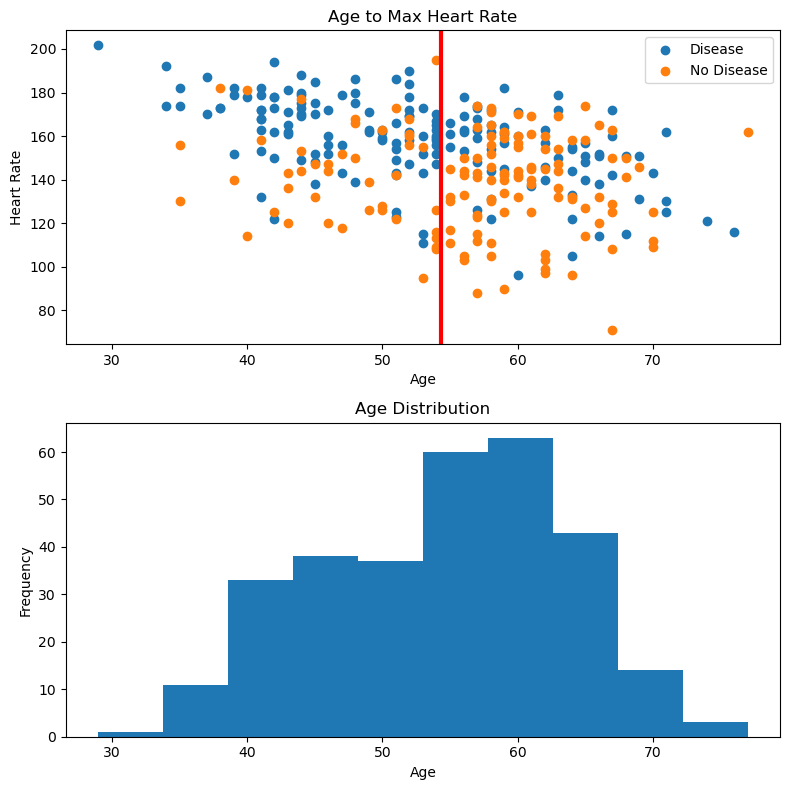

In [100]:
fig, ax = plt.subplots(figsize = (8,8), ncols=1, nrows = 2)

#scatter age and thalach for patients with heart disease
ax[0].scatter(heart_disease.age[heart_disease.target==1],heart_disease.thalach[heart_disease.target==1],     )            

#scatter age and thalach for patients without heart disease
ax[0].scatter(heart_disease.age[heart_disease.target==0],heart_disease.thalach[heart_disease.target==0],     )

#customize scatter plot
ax[0].set(title= "Age to Max Heart Rate", 
        xlabel="Age",
        ylabel="Heart Rate" 
       );

ax[0].legend(("Disease","No Disease"));

#draw age meanline
ax[0].axvline(heart_disease["age"].mean(), 
           linestyle = "-" , c= "red", linewidth = 3
              );

ax[1] = heart_disease["age"].plot.hist(title = "Age Distribution");
ax[1].set(xlabel = "Age")

fig.tight_layout()

### Observations: 
- Younger patients tend to have higher heart rates and are less likely to have heart disease. 
- Age distribution replicates a bell curve.
    -  No outliers, data doesn't need to be removed
    - Majority of the patients are 55-65 years of age



### Does chest pain type correlate with heart disease?

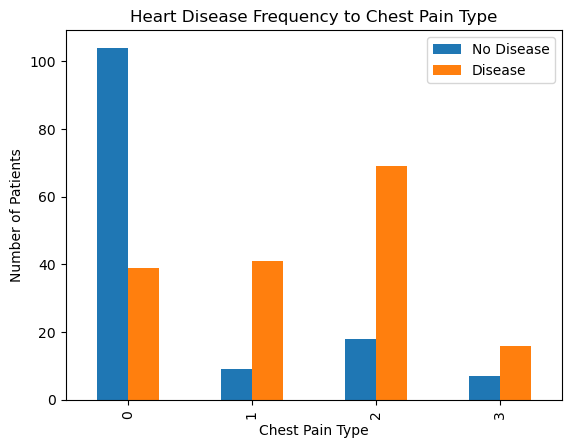

In [80]:
pd.crosstab(heart_disease["cp"], heart_disease["target"]).plot.bar();

plt.title("Heart Disease Frequency to Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Number of Patients")
plt.legend(("No Disease", "Disease"));


### Observation: 
- Surprisingly, majority of the patients stuggling with Non-anginal chest pain, pain type 2 which is not heart related, have heart disease. 

### Correlation Matrix

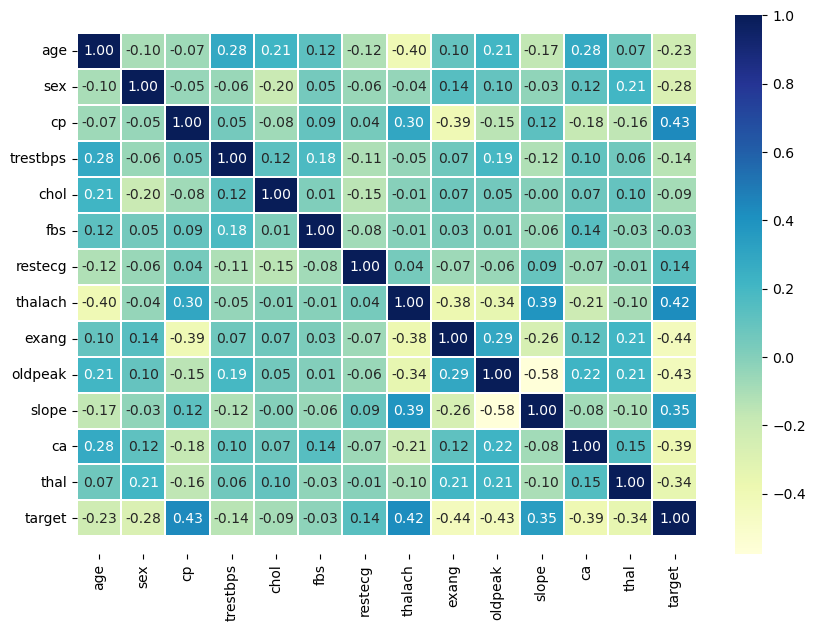

In [81]:
corr_mat=heart_disease.corr()
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.heatmap(corr_mat,
           annot=True,
           linewidths=0.1,
           fmt = ".2f",
        cmap="YlGnBu"
        );
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

# Experimenting with Models 

- Evaluate baseline acccuracy for the following classifiers using their default parameters.

    - KNeighbors Classifier
    - Logistic Regression
    - Random Forest Classifier
    - CatBoost Classifier
    - XGBoost Classifier



### Split train and test datasets

In [11]:
X = heart_disease.drop("target", axis = 1)
y = heart_disease["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Functionize Fitting and Evaluating Models
   - Create a function  that fits and evaluates given models on given datasets and returns scores in a dictionary format

In [82]:
models = {    
    "KNeighbors_Classifier": KNeighborsClassifier(),
    "Logistic_Regression": LogisticRegression(),
    "RandomForest_Classifier": RandomForestClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=False),
    "XGBClassifier" : XGBClassifier()
}

In [67]:
def model_fit_and_score(models, X_train, y_train, X_test, y_test):    
    
    '''
        Fits given models on train data, evaluates on test data and returns their 
        accuracy. 
    '''
    
    #Set empty dictionary to store model's scores
    model_scores = {}
    
    #Loops through the models 
    for name, model in models.items():
        
        #Fit the model to the training data
        model.fit(X_train,y_train)
        
        #Evaluate the model on testing data and append score to model scores
        model_scores[name] = round(model.score(X_test, y_test)*100, 2)
        
     
    return model_scores


### Dataframe for Model results

In [15]:
model_scores_baseline = model_fit_and_score(models, X_train, y_train, X_test, y_test)
model_comparison_results = pd.DataFrame(model_scores_baseline,
                                   index = ["Baseline Accuracy" ]
                               ).T

### Visualize Model Results 

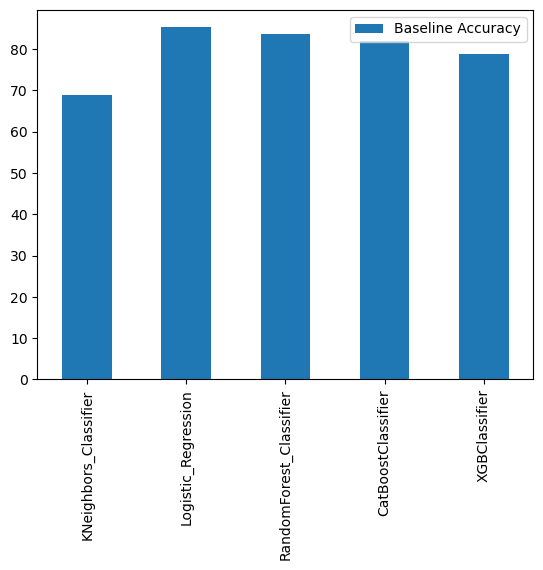

In [16]:
model_comparison_results.plot.bar();

### Key Note:
- We can try hyperparameter tuning each model using RandomSearchCV to improve their performance. 
    

## Hyperparameter Tuning KNeighbors Classifier using RandomSearchCV

In [17]:
#differernt hyperparameters for KNN
grid_knn= {
    "n_neighbors":[1,2,4,8,10,11,13,15],
    "weights":['uniform'],
    "algorithm":['auto'],
    "leaf_size":[30],
    "p":[2],
    "metric":['minkowski'],
}

#create random search cv model
rs_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(n_jobs=1),
                           param_distributions=grid_knn,
                           n_iter=20,
                           cv=5,
                           verbose=0)
#fit random search model
rs_knn.fit(X_train, y_train)

#random search model best parameters
rs_knn.best_params_

#evaluate random search model on test data
rs_knn_score = round(rs_knn.score(X_test, y_test)*100,2)

print(f'Baseline KNN model accuracy: {model_scores_baseline["KNeighbors_Classifier"]}%')
print(f'Hyperparameter tuned KNN model accuracy : {rs_knn_score}% \n')


Baseline KNN model accuracy: 68.85%
Hyperparameter tuned KNN model accuracy : 70.49% 



/Users/suranjitmohajan/anaconda3/envs/py3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Hyperparameter Tuning Logistics Regressor using RandomSearchCV

In [18]:
#differernt hyperparameters for log reg
grid_log_reg = {
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear"]
}


#create random search cv model
rs_log_reg = RandomizedSearchCV(    
    estimator=LogisticRegression(),
    param_distributions=grid_log_reg,
    n_iter=20,
    cv=5,
    verbose=0,    
)

#fit random search model
rs_log_reg.fit(X_train,y_train)

#random search model best parameters
rs_log_reg.best_params_

#evaluate random search model on test data
rs_log_reg_score = round(rs_log_reg.score(X_test, y_test)*100,2) 

print(f'Baseline Logistic Regression model accuracy: {model_scores_baseline["Logistic_Regression"]}%')
print(f'Hyperparameter tuned Logistic Regression model accuracy: {round(rs_log_reg.score(X_test, y_test)*100,2)}% \n')


Baseline Logistic Regression model accuracy: 85.25%
Hyperparameter tuned Logistic Regression model accuracy: 86.89% 



## Hyperparameter Tuning Random Forest Classifier using RandomSearchCV

In [19]:
#differernt hyperparameters for random forest clf
grid_rf_clf = {
           "n_estimators": np.arange(10,1000, 50),
           "max_depth": [3, 5, 10, None],
           "min_samples_split": np.arange(2,20, 2),
           "min_samples_leaf":  np.arange(1,20, 1)
}


#create random search cv model
rs_rf_clf = RandomizedSearchCV(

estimator=RandomForestClassifier(),
param_distributions=grid_rf_clf,
n_iter=20,
cv=5,
verbose=False
    
)

#fit random search model
rs_rf_clf.fit(X_train, y_train)

#random search model best parameters
rs_rf_clf.best_params_

#evaluate random search model on test data
rs_rf_clf_score = round(rs_rf_clf.score(X_test,y_test)*100,2) 

print(f'Baseline Random Forest Classifier accuracy: {model_scores_baseline["RandomForest_Classifier"]}%')
print(f'Hyperparameter tuned Random Forest Classifier accuracy: {rs_rf_clf_score}%')


Baseline Random Forest Classifier accuracy: 83.61%
Hyperparameter tuned Random Forest Classifier accuracy: 85.25%


## Hyperparameter Tuning CatBoost Classifier using RandomSearchCV

In [20]:
#create train and validation datasets
train_dataset = cb.Pool(X_train, y_train) 
validation_dataset = cb.Pool(X_test, y_test)

#instantiate catboost model
rs_catboost_clf = cb.CatBoostClassifier(verbose=0)

#catboost parameter grid
grid = {'iterations': [50, 100, 150],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],         
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
 
#fit random search CV model 
rs_catboost_clf.randomized_search(grid, 
                        train_dataset, 
                        n_iter= 20,
                        cv = 5, 
                        verbose = False)

#random search CV best parameters
rs_catboost_clf.get_params()

#evaluate random search CV model on test data
rs_catboost_clf_score = round(rs_catboost_clf.score(X_test, y_test)*100,2)


print(f'Baseline CatBoost Classifier accuracy: {model_scores_baseline["CatBoostClassifier"]}%')
print(f'Hyperparameter tuned CatBoost Classifier accuracy: {round(rs_catboost_clf.score(X_test, y_test)*100,2)}% \n')




bestTest = 0.4139164634
bestIteration = 97


bestTest = 0.3628372861
bestIteration = 96



/Users/suranjitmohajan/anaconda3/envs/py3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,



bestTest = 0.4109426534
bestIteration = 99


bestTest = 0.3640150812
bestIteration = 118


bestTest = 0.4284580295
bestIteration = 49


bestTest = 0.3883049651
bestIteration = 24


bestTest = 0.376804254
bestIteration = 47


bestTest = 0.376804254
bestIteration = 47


bestTest = 0.4003006503
bestIteration = 139


bestTest = 0.376804254
bestIteration = 47


bestTest = 0.4510805866
bestIteration = 49


bestTest = 0.4339249806
bestIteration = 49


bestTest = 0.4365041213
bestIteration = 34


bestTest = 0.4185962153
bestIteration = 48


bestTest = 0.460192779
bestIteration = 13


bestTest = 0.4490303551
bestIteration = 22


bestTest = 0.4509747335
bestIteration = 49


bestTest = 0.4442172447
bestIteration = 48


bestTest = 0.4463909613
bestIteration = 25


bestTest = 0.4549026981
bestIteration = 34

Training on fold [0/5]

bestTest = 0.384533917
bestIteration = 97

Training on fold [1/5]

bestTest = 0.4273104909
bestIteration = 67

Training on fold [2/5]

bestTest = 0.3408166525
bestItera

## Hyperparameter Tuning XGBoost Classifier using RandomSearchCV

In [21]:
#different Xgboost clf hyperparameters
grid = {
    "n_estimators": np.arange(10,100, 10),
    "max_depth": [None, 5, 10],    
    "eta" : [0.1, 0.2],
    "colsample_bytree": [0.8, 0.6],
    "subsample": [0.025],
 }

#create random search CV model 
rs_xgboost_clf = RandomizedSearchCV(estimator=XGBClassifier(),
                              param_distributions=grid,
                              n_iter=20,
                              cv = 5,
                              verbose=False
                         )

#fit xgboost model
rs_xgboost_clf.fit(X_train, y_train)

#xgboost model best parameters
rs_xgboost_clf.best_params_

#evaluate xgboost model on test data
rs_xgboost_clf_score = round(rs_xgboost_clf.score(X_test, y_test)*100,2)


print(f'Baseline XGBoost Classifier accuracy: {model_scores_baseline["XGBClassifier"]}%')
print(f'Hyperparameter tuned XGBoost Classifier accuracy: {rs_xgboost_clf_score}% \n')


Baseline XGBoost Classifier accuracy: 78.69%
Hyperparameter tuned XGBoost Classifier accuracy: 75.41% 



### Dataframe containing Baseline and RandomSearchCV scores

In [23]:
model_comparison_results["RS Accuracy"] = [rs_knn_score,
                                          rs_log_reg_score,
                                          rs_rf_clf_score,
                                          rs_catboost_clf_score,
                                          rs_xgboost_clf_score]

model_comparison_results

,Baseline Accuracy,RS Accuracy
KNeighbors_Classifier,68.85,70.49
Logistic_Regression,85.25,86.89
RandomForest_Classifier,83.61,85.25
CatBoostClassifier,81.97,83.61
XGBClassifier,78.69,75.41


### Key Note:
- Since Logistic Regression yielded the highest score, we can try tuning further using GridSearchCV

## Hyperparameter Tuning Logistic Regression using  GridSearchCV

In [36]:
#differernt hyperparameters for log reg
grid_log_reg = {
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear"]
}


#create grid search cv model
gs_log_reg = GridSearchCV(    
    estimator=LogisticRegression(),
    param_grid=grid_log_reg,
    cv=5,
    verbose=0,    
)

#fit grid search model
gs_log_reg.fit(X_train,y_train)

#grid search model best parameters
gs_log_reg.best_params_

#evaluate grid search model on test data
gs_log_reg_score = round(gs_log_reg.score(X_test, y_test)*100,2) 

print(f'Baseline Logistic Regression model accuracy: {model_scores_baseline["Logistic_Regression"]}% \n')
print(f'Hyperparameter tuned RS Logistic Regression model accuracy: {round(rs_log_reg.score(X_test, y_test)*100,2)}% \n')
print(f'Hyperparameter tuned GS Logistic Regression model accuracy: {round(gs_log_reg.score(X_test, y_test)*100,2)}% \n')


Baseline Logistic Regression model accuracy: 85.25% 

Hyperparameter tuned RS Logistic Regression model accuracy: 86.89% 

Hyperparameter tuned GS Logistic Regression model accuracy: 86.89% 



### Observation: 
Logistic Regression using Grid Search and Random Search yielded the same score.

# Model Evaluations



Predict and evaluate Logistic Regression using the following metrics:
- ROC curve and AUC score (True positive / False Positive)
- Confusion matrix
- Classification RPT
- Precision
- Recall
- F1-score

Use CV where possible


### Make Predictions using Logistic Regression 

In [37]:
y_preds =  gs_log_reg.predict(X_test)

###  ROC curve and AUC score 

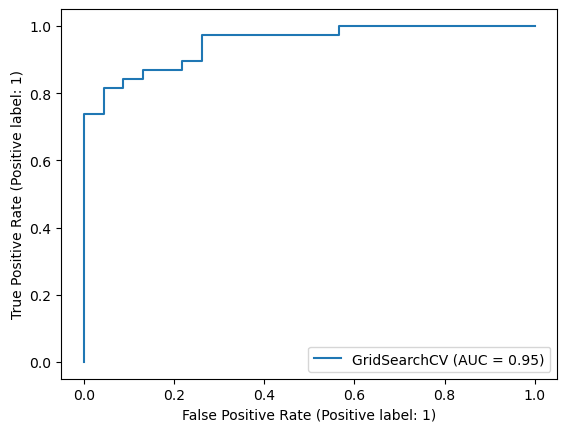

In [38]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test); 

### Confusion Matrix

- Create a function that plots a confusion matrix with given parameters, true labels and predicted labels


In [39]:
def plot_conf_mat(y_true,y_preds):
    
    '''
        Plots a confusion matrix using Seaborn
    '''
    fig, ax = plt.subplots(figsize = (5,4))

    ax = sns.heatmap(confusion_matrix(y_true, y_preds),
                    annot=True #shows the counts 
                    );

    ax.set(
        xlabel = "True label", #sets true labels on X axis
        ylabel="Predicted label" #sets predictions on y axis
    );

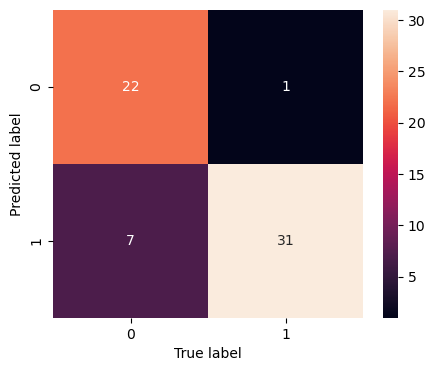

In [40]:
plot_conf_mat(y_test,y_preds)

### Classification Report

In [41]:
class_rpt = classification_report(y_test, y_preds)
print(class_rpt)

              precision    recall  f1-score   support

           0       0.76      0.96      0.85        23
           1       0.97      0.82      0.89        38

    accuracy                           0.87        61
   macro avg       0.86      0.89      0.87        61
weighted avg       0.89      0.87      0.87        61



### Calculate the following metrics using Cross-Validation
- use best parameters from grid search 

     - accuracy
     - precision
     - recall
     - f1 score
- CV split of 5


### GridSearchCV best parameters

In [42]:
gs_log_reg.best_params_

{'C': 0.615848211066026, 'solver': 'liblinear'}

### Create new classifier with best parameters

In [96]:
clf = LogisticRegression(C = 0.615848211066026,
                        solver = 'liblinear')

clf.fit(X_train, y_train)

LogisticRegression(C=0.615848211066026, solver='liblinear')

### Cross Validated Accuracy

In [84]:
cv_accuracy = np.mean(cross_val_score(clf,
               X,
               y,
               cv = 5,
               scoring = "accuracy")) 

### Cross Validated Precision

In [85]:
cv_precision = np.mean(cross_val_score(clf,
               X,
               y,
               cv = 5,
               scoring = "precision")) 

### Cross Validated Recall

In [86]:
cv_recall = np.mean(cross_val_score(clf,
               X,
               y,
               cv = 5,
               scoring = "recall"))

### Cross Validated F1

In [87]:
cv_f1 = np.mean(cross_val_score(clf,
               X,
               y,
               cv = 5,
               scoring = "f1"))

### Visualize cross-validated metrics


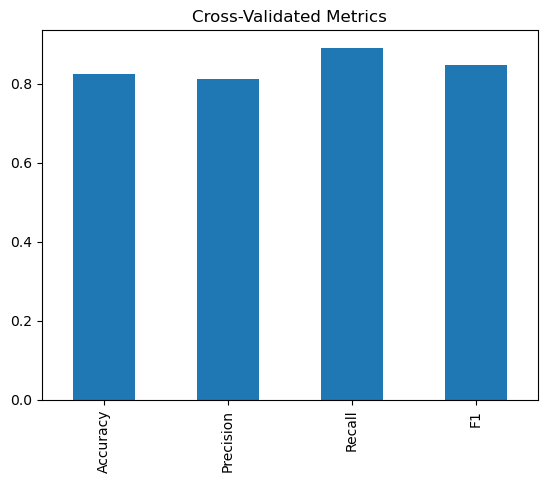

In [90]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame((cv_accuracy,
                           cv_precision,
                           cv_recall, 
                           cv_f1),
                          index=["Accuracy",
                                 "Precision",
                                 "Recall",
                                 "F1"])

cv_metrics.plot.bar(title = "Cross-Validated Metrics",
                   legend = False);

## Feature Importance 

- Which features contributed the most to the model outcomes?
- How did they contribute? Positive / Negative?

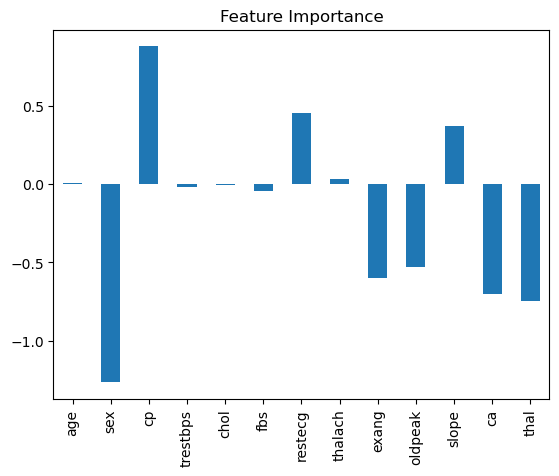

In [91]:
feature_importance = pd.DataFrame(list(clf.coef_[0]),
            index=X.columns)

feature_importance.plot.bar(title="Feature Importance", legend = False);

### Few Observations: 
   - When the value for Sex increases, chances of being a male, the chances of having heart disease decreases.
   - When the value of slope increases, gets closer to Downslopins, signs of an unhealthy heart, the chance of having heart disease increases. 
   - The higher the ca, more blood movement (no clots), the less likely patient is expected to have heart disease. 